<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Seminar #1: Inroduction into Time Series Analysis

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h3> Plan </h3>
  * **Remind: Regression**
  * **Autoregression Model**
  * **HW** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import scipy as sc

%matplotlib inline

<h1 align="center"> Remind: Regression </h1>

In [2]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#examples-using-sklearn-linear-model-linearregression", width=800, height=400)

In [3]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge", width=800, height=400)

## Underfitting VS Overfitting

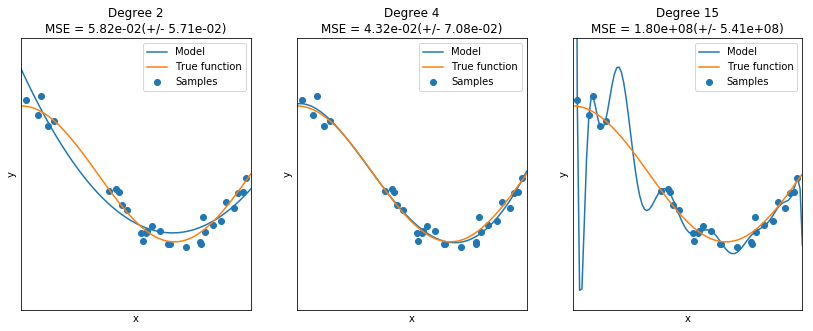

In [4]:
np.random.seed(0)

n_samples = 30
degrees = [2, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X) # ещё один способ определить функцию: с помощью lambda-функции

# Data Generation
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = model_selection.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

<h1 align="center"> Autoregression</h1>

## Data: energy consumption

In [3]:
# Caution: different version of pandas needs differnt codes!!!
# ts = pd.read_csv('consumption_train.csv', sep='\t', decimal=',')
ts = pd.read_csv('consumption_train.csv', sep='\t', decimal='.', parse_dates=True, dayfirst=False, index_col='Dates') 
ts.head(24)

,EnergyCons,Dev,WeekDay
Dates,,,
2005-01-01 00:00:00,1290,-11,6
2005-01-01 01:00:00,1266,-12,6
2005-01-01 02:00:00,1273,-13,6
2005-01-01 03:00:00,1280,-14,6
2005-01-01 04:00:00,1293,-15,6
2005-01-01 05:00:00,1263,-16,6
2005-01-01 06:00:00,1279,-16,6
2005-01-01 07:00:00,1304,-16,6
2005-01-01 08:00:00,1330,-16,6


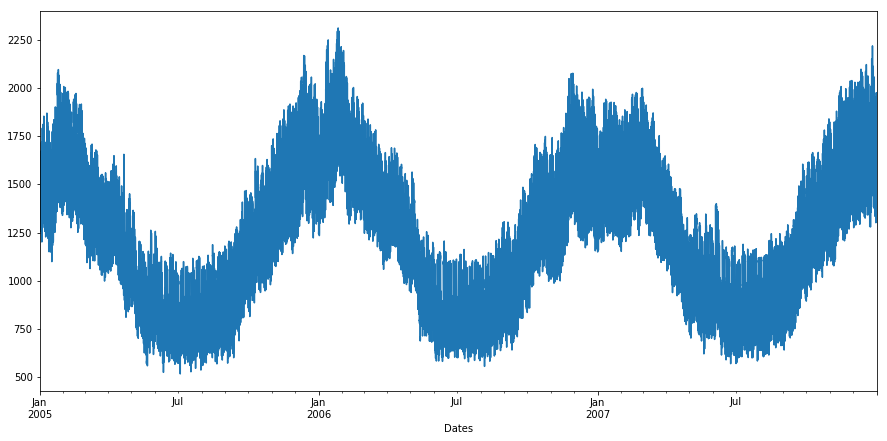

In [6]:
# Plot time series
ts['EnergyCons'].plot(figsize=(15,7))

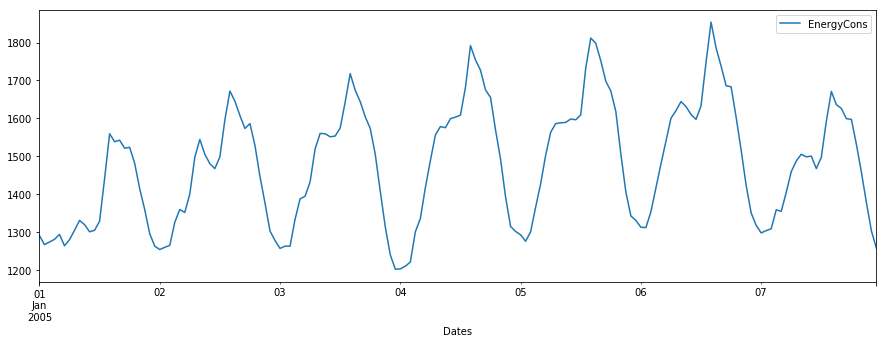

In [7]:
# the first week
ts.ix['2005-01-01 00:00:00':'2005-01-07 23:00:00', range(1)].plot(figsize=(15,5))

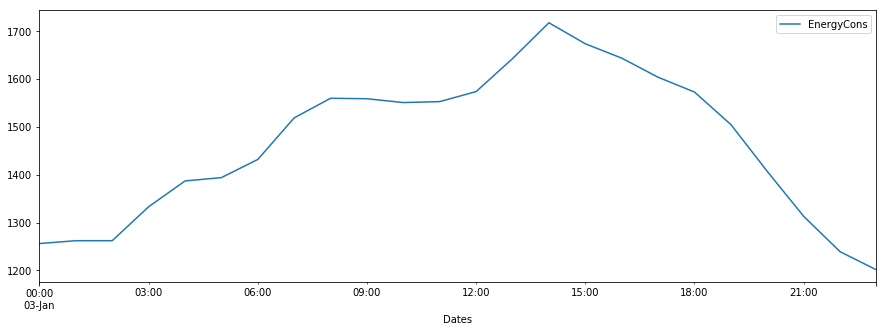

In [8]:
# the first day
ts.ix['2005-01-03 00:00:00':'2005-01-03 23:00:00', range(1)].plot(figsize=(15,5))

## STL-decomposition

In [9]:
import statsmodels.api as sm

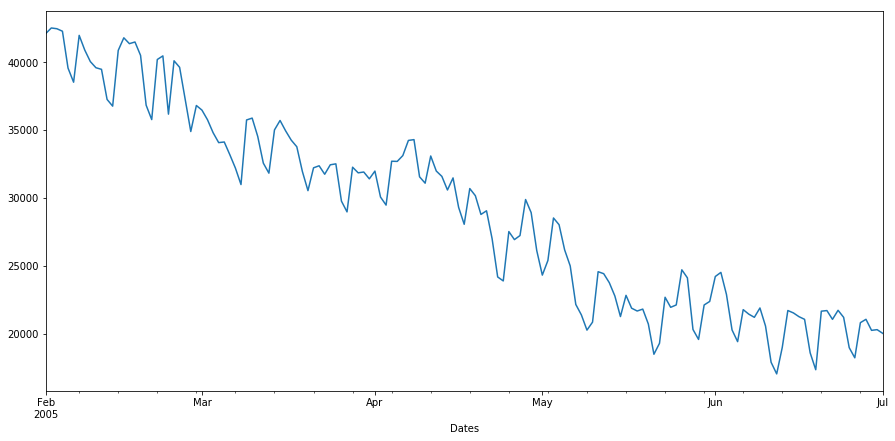

In [10]:
ts['EnergyCons'].ix['2005-02-01 00:00':'2005-07-01 23:00'].resample("D").sum().plot(figsize=(15,7))

In [11]:
res = sm.tsa.seasonal_decompose(ts['EnergyCons'].ix['2005-02-01 00:00':'2005-07-01 23:00'].resample("D").sum())
resplot = res.plot()

ValueError: freq D not understood. Please report if you think this in error.

In [ ]:
# fig = plt.figure(figsize=(15,10))
res = sm.tsa.seasonal_decompose(ts['EnergyCons'].ix['2005-02-01 00:00':'2008-01-01 23:00'].resample("M").sum())
resplot = res.plot()

## Autoregression: build matrix of autoregression

In [13]:
sc.linalg.hankel([1,2,3], [4,7,7,8,9])

array([[1, 2, 3, 7, 7],
       [2, 3, 7, 7, 8],
       [3, 7, 7, 8, 9]])

In [5]:
def get_autoregrmatrix(x,h,K):
    L = len(x)
    X = sc.linalg.hankel(x[:L-h-K+1], x[-K:])
    y = x[K+h-1:]
    return X,y

## Forecast for next hour (h=1) using 1 week history (K=168)

In [15]:
K=168
h = 1 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

In [16]:
print(X_train.shape)
print(y_train.shape)

(8593, 168)
(8593,)


In [17]:
# Matrix of Samples and Regressors
X_train

array([[1290, 1266, 1273, ..., 1377, 1302, 1256],
       [1266, 1273, 1280, ..., 1302, 1256, 1257],
       [1273, 1280, 1293, ..., 1256, 1257, 1267],
       ..., 
       [1332, 1293, 1225, ..., 1541, 1394, 1349],
       [1293, 1225, 1222, ..., 1394, 1349, 1312],
       [1225, 1222, 1278, ..., 1349, 1312, 1284]])

In [18]:
# Target Vector
y_train

Dates
2005-01-08 00:00:00    1257
2005-01-08 01:00:00    1267
2005-01-08 02:00:00    1274
2005-01-08 03:00:00    1339
2005-01-08 04:00:00    1376
2005-01-08 05:00:00    1400
2005-01-08 06:00:00    1439
2005-01-08 07:00:00    1504
2005-01-08 08:00:00    1557
2005-01-08 09:00:00    1518
2005-01-08 10:00:00    1500
2005-01-08 11:00:00    1501
2005-01-08 12:00:00    1546
2005-01-08 13:00:00    1645
2005-01-08 14:00:00    1718
2005-01-08 15:00:00    1701
2005-01-08 16:00:00    1655
2005-01-08 17:00:00    1635
2005-01-08 18:00:00    1616
2005-01-08 19:00:00    1530
2005-01-08 20:00:00    1435
2005-01-08 21:00:00    1349
2005-01-08 22:00:00    1266
2005-01-08 23:00:00    1247
2005-01-09 00:00:00    1227
2005-01-09 01:00:00    1252
2005-01-09 02:00:00    1250
2005-01-09 03:00:00    1298
2005-01-09 04:00:00    1355
2005-01-09 05:00:00    1384
                       ... 
2005-12-30 19:00:00    1682
2005-12-30 20:00:00    1586
2005-12-30 21:00:00    1484
2005-12-30 22:00:00    1401
2005-12-30 23:

Train score: 0.917, Test score: 0.743


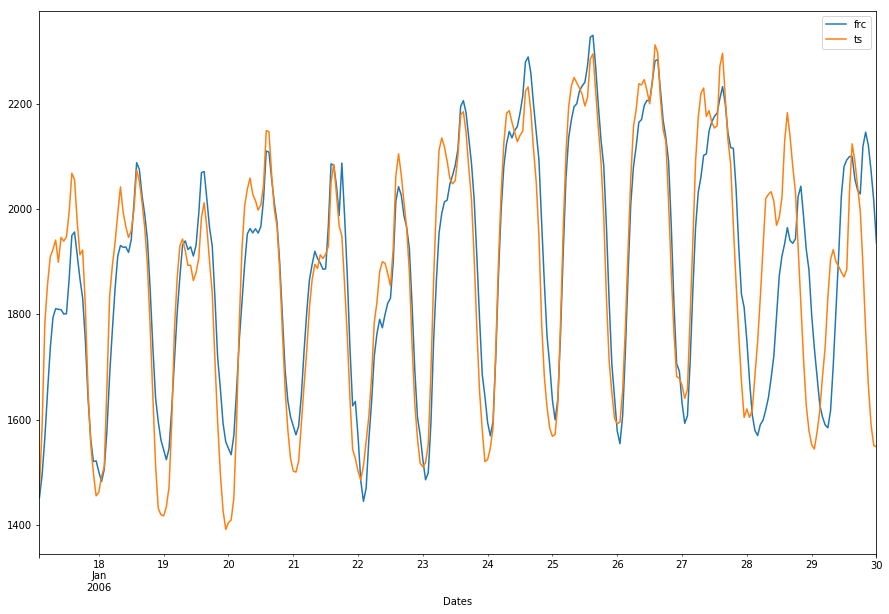

In [23]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize=(15,10))

## Try another delay: h=168

Train score: 0.934, Test score: 0.871


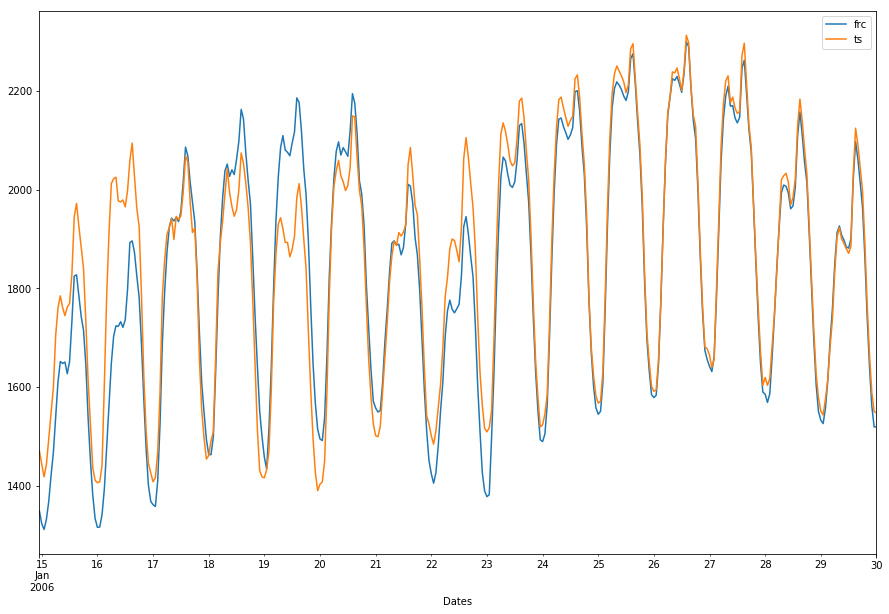

In [30]:
K=168
h = 168 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize=(15,10))

<h1 align="center"> Home Work 0</h1>

## Answer to questions 
  ** 1. What is time series? **
     
     Time series is a squance of values measured by constant interval of some varible
       
  ** 2. What is delay and horizon of forecast?**
   
     Its the time interval between current forcasting time and last known time and horizon of forecast is the delay The future period of time for which a forecast is generated.
         
  ** 3. What is Least Squared Method for Linear Regression?**
  
     Find the Linear predictor which minimizes the sum of squares of distances between prediced labels and original labels
          
  ** 4. What is the solution of linear regression via LS method (in terms of matrix $X, \alpha, Y$)? **
  
$      \alpha = (X^TX)^{-1}X^TY$
          
  ** 5. Write down main problems of LS method. **
  
     It does't adapt so well
          
  ** 6. What hankel transformation of a matrix? **
  
$      A_{i,j} = A_{i+1,j-1} = A_{i-1,j+1} $
          

## Practical Task
Draw dependence of the cross_validation score (linear_regression.score) on the horizon of the forecast for LR model in the case of energy consumption forecasting. You should write code to show dependence for $h=1,2,\dots, 720$. You can choose amount of regressors fo LR in experiment as much as you want.   

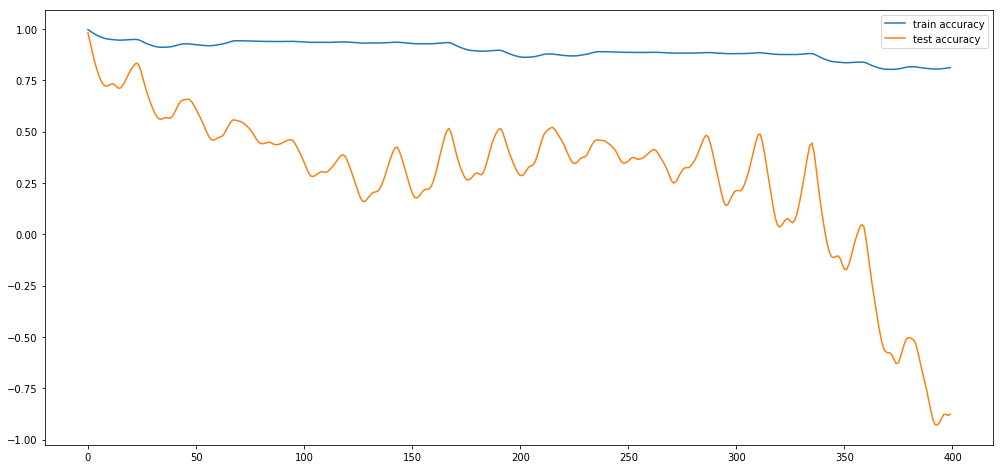

In [17]:
x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']
scores = np.zeros((400,2))
K = 100
for h in range(1,401):
    
    X_train, y_train = get_autoregrmatrix(x_train,h,K)
    X_test, y_test = get_autoregrmatrix(x_test,h,K)
    linear_regression = LinearRegression()
    linear_regression.fit(X_train,y_train)
    scores[h-1,0] = linear_regression.score(X_train, y_train)
    scores[h-1,1] = linear_regression.score(X_test, y_test)

plt.figure(figsize=(17,8))
plt.plot(scores[:,0],label='train accuracy')
plt.plot(scores[:,1], label='test accuracy')
plt.legend()
plt.show()